#### Predictive Models Cancer datasets
- Pancreatic Cancer Gene prediction with Autoencoder (AE)
- Transcription factor binding site (TFBS)
- Lung cancer model and gene expression**


#### **Pancreatic Cancer Gene prediction with Autoencoder (AE) **

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense, Activation, Flatten, Layer, Dropout
from keras.layers import LSTM, Bidirectional
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#### Autoencoder

In [ ]:
lung_ds= pd.read_csv('pancan_scaled_zeroone_rnaseq.tsv', sep='\t', index_col=0)
lung_ds.head()[:2]

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560


In [ ]:
X_train, X_test = train_test_split(lung_ds, test_size=0.2, shuffle=True)
embedding_dim = 500
number_of_features = lung_ds.shape[1]
autoencoder = Sequential()
autoencoder.add(Dense(embedding_dim, activation='relu', input_shape=(number_of_features,)))
autoencoder.add(Dense(number_of_features, activation='sigmoid'))
autoencoder.compile(optimizer='adam', loss='mse')
hist = autoencoder.fit(np.array(X_train), np.array(X_train), shuffle=True,
    epochs=10, batch_size=64, validation_split=0.2)

Text(0, 0.5, 'reconstruction loss')

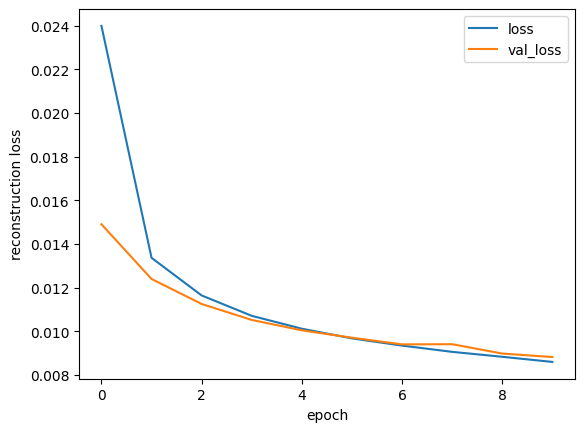

In [ ]:
hist_df = pd.DataFrame(hist.history)
ax = hist_df.plot()
ax.set_xlabel('epoch') ; ax.set_ylabel('reconstruction loss')

In [ ]:
input_sample = X_test[:1]
reconstruction = autoencoder.predict(lung_ds)
reconstruction_df = pd.DataFrame(reconstruction, columns=lung_ds.columns)
reconstruction_fidelity =  pd.DataFrame(
    np.array(reconstruction_df) - np.array(lung_ds), columns=lung_ds.columns)

327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


In [ ]:
gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(lung_ds.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene_mean','gene_abssum']).T
gene_summary.sort_values(by='gene_abssum', ascending=False, inplace=True)
gene_summary.head()

,gene_mean,gene_abssum
GSTT1,-0.027700,0.224473
PPAN-P2RY11,-0.000740,0.222441
GSTM1,0.028900,0.212991
TBC1D3G,0.016360,0.192889
RPS28,0.002447,0.169518


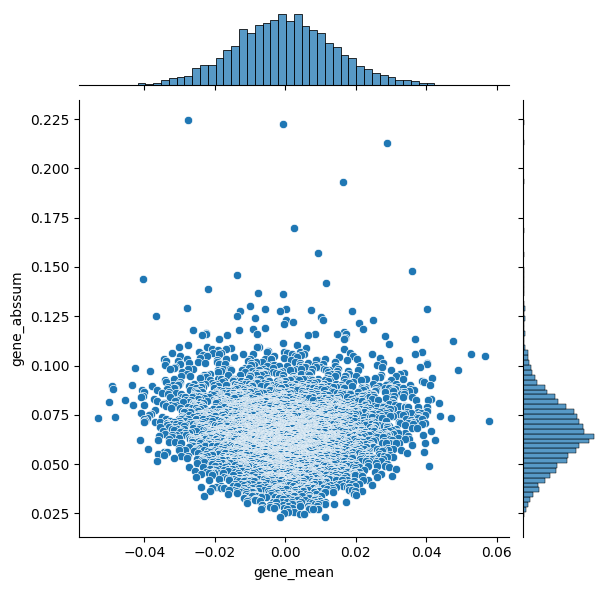

In [ ]:
sns.jointplot(x='gene_mean', y='gene_abssum', data=gene_summary, kind='scatter')

#### **Transcription factor binding site (TFBS)**

- train a model on DNA data containing binding sites for proteins and
make predictions for TBFS

- for predicting a transcription factorbinding site, TBFS, problem we use either
CNN or RNN, BiLSTM or MLP algorithm

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import auc, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt

In [ ]:
fasta_ds = pd.read_table('sequences_mod.txt', header=None)
fasta_ds.rename(columns={0: 'sequence'}, inplace=True)
labels_ds = pd.read_table('labels.txt', header=None)
labels_ds.rename(columns={0: 'label'}, inplace=True)
input_encoder = LabelEncoder()
output_hot_encoder = OneHotEncoder()
sequences_matrix = []
for sequence in fasta_ds.sequence:
  input_encoder_data = input_encoder.fit_transform(list(sequence))
  input_encoder_data = input_encoder_data.reshape(-1, 1)
  output_hot_encoder_data = output_hot_encoder.fit_transform(input_encoder_data)
  sequences_matrix.append(output_hot_encoder_data.toarray())
sequences_matrix = np.stack(sequences_matrix)

In [ ]:
labels_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   2001 non-null   int64
dtypes: int64(1)
memory usage: 15.8 KB


In [ ]:
fasta_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


In [ ]:
Y = np.array(labels_ds.label)[1:2001]
Y = Y.reshape(-1)
Y, Y.shape

(array([0, 0, 0, ..., 0, 1, 1]), (2000,))

In [ ]:
pd.DataFrame(Y).info(), pd.DataFrame(Y).value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       2000 non-null   int64
dtypes: int64(1)
memory usage: 15.8 KB


(None,
 0
 0    1013
 1     987
 Name: count, dtype: int64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    sequences_matrix, Y, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, y_train.shape

((1500, 50, 4), (1500,))

In [ ]:
X_train_keras = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_keras = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_train_keras.shape, X_test_keras.shape

((1500, 50, 4, 1), (1500, 50, 4, 1))

In [ ]:
y_train.shape, y_test.shape

((1500,), (500,))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6357 - loss: 0.2252 - val_accuracy: 0.7400 - val_loss: 0.1569
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.1205 - val_accuracy: 0.8800 - val_loss: 0.0976
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9318 - loss: 0.0685 - val_accuracy: 0.9667 - val_loss: 0.0598
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9656 - loss: 0.0405 - val_accuracy: 0.9800 - val_loss: 0.0384
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9871 - loss: 0.0206 - val_accuracy: 0.9867 - val_loss: 0.0295
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9886 - loss: 0.0144 - val_accuracy: 0.9867 - val_loss: 0.0184
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9970 - loss: 0.0081 - val_accuracy: 0.9933 - val_loss: 0.0163
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9975 - loss: 0.0056 - val_accuracy: 0.9933 - val_

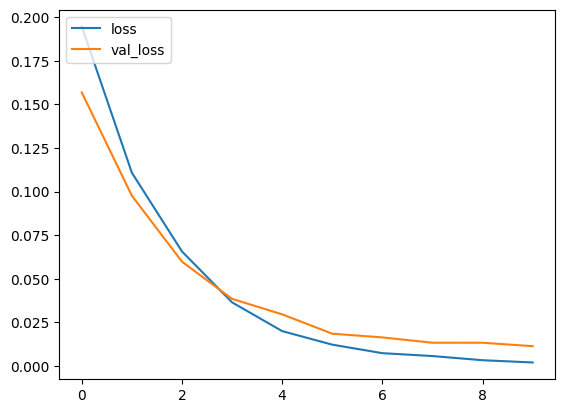

In [ ]:
''' CNN model '''
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, activation='relu',
                 input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary(),
hist = model.fit(X_train_keras, y_train, batch_size=10, epochs=10, validation_split=.1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')

In [ ]:
pred = model.predict(X_test_keras, batch_size=32).flatten()
fpred, tpred, thresholds = roc_curve(y_test, pred)
auc(fpred, tpred), average_precision_score(y_test, pred)
pred, pred.shape, hist.history['accuracy']

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(array([0.0683755 , 0.9931696 , 0.9747913 , ..., 0.05637105, 0.15233232,
        0.9125539 ], dtype=float32),
 (1500,),
 [0.7162963151931763,
  0.8570370078086853,
  0.9311110973358154,
  0.970370352268219,
  0.9896296262741089,
  0.9925925731658936,
  0.9962962865829468,
  0.9962962865829468,
  1.0,
  1.0])

In [ ]:
plt_ids = np.random.randint(0, len(X_test_keras), 1)
sequences_matrix.shape
plt_sequences_matrix = sequences_matrix.reshape(
    (sequences_matrix.shape[0], sequences_matrix.shape[1],
     sequences_matrix.shape[2], 1))[plt_ids, :]
plt_sequences_matrix_pred = model.predict(
    plt_sequences_matrix, batch_size=32).flatten()
plt_sequences_matrix.shape, plt_sequences_matrix_pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


((1, 50, 4, 1), (1,))

In [ ]:
''' continue with the gradient and the prediction
for each sequence every nucleotide '''

pancreate rnaseq

In [ ]:
''' a second dataset, pancreate rnaseq data '''
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1000, 1000, 4), (100, 1000, 4), (1000, 690), (100, 690))

In [ ]:
input_data = Input(shape=[1000,4])
''' conv layer '''
output = Conv1D(320,kernel_size=26, activation='relu')(input_data)
output = MaxPooling1D()(output)
output = Dropout(0.2)(output)
''' bidirectional LSTM layer '''
output = Bidirectional(LSTM(320,return_sequences=True))(output)
output = Dropout(0.5)(output)
flat_output = Flatten()(output)
''' fc layer '''
fc_output = Dense(695)(flat_output)
fc_output = Activation('relu')(fc_output)
''' output layer '''
output = Dense(690)(fc_output)
output = Activation('sigmoid')(output)
model = Model(inputs=input_data, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()
checkpointer = ModelCheckpoint(
    filepath="bilstm_model.keras", verbose=1, save_best_only=False)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(X_train, y_train, batch_size=100, epochs=2, shuffle=True,
    verbose=1, validation_split=0.1, callbacks=[checkpointer,earlystopper])
training_loss = np.mean(history.history['loss'])
validation_loss = np.mean(history.history['val_loss'])

Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - loss: 0.4846 
Epoch 1: saving model to bilstm_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 277s 31s/step - loss: 0.4677 - val_loss: 0.0502
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - loss: 0.0902 
Epoch 2: saving model to bilstm_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 453s 47s/step - loss: 0.0897 - val_loss: 0.0511


In [ ]:
training_loss, validation_loss
history.history['loss'], history.history['val_loss']

([0.31521376967430115, 0.08464924246072769],
 [0.05018356442451477, 0.051117029041051865])

#### **Lung cancer model and gene expression**

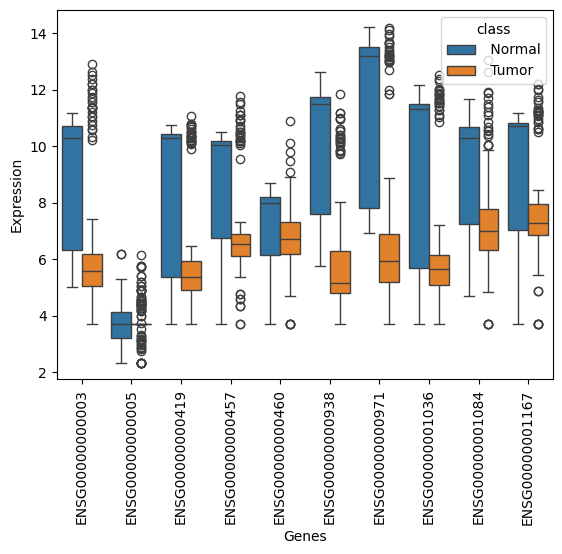

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

''' load the files '''
lung_ds= pd.read_csv('lung_ds.csv')
''' missing values for all genes '''
lung_ds.isna().sum()
''' EDA '''
lung_ds['class'] = lung_ds['class'].replace('Normal', 'Normal')
lung_ds['class'] = lung_ds['class'].replace('Tumor', 'Tumor')
dfx = lung_ds['class'].value_counts().reset_index()
sns.barplot(x='count', y='class', data=dfx)
plt.xlabel('number of samples') ; plt.ylabel('Class') ; plt.show()
''' distribution of expressions across the samples '''
lung_ds_m = pd.melt(lung_ds.iloc[:, 1:12], id_vars='class')
ax = sns.boxplot(x='variable', y='value', data=lung_ds_m, hue='class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90 )
plt.xlabel('Genes') ; plt.ylabel('Expression') ; plt.show()

In [ ]:
''' Model training and evaluation '''
X = lung_ds.drop(['class','ID'], axis=1).values
y_tmp = lung_ds['class'].values
classes = lung_ds['class'].unique().tolist()
fn_ = lambda x: classes.index(x)
y = np.array([fn_(i) for i in y_tmp], dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42, stratify=y)
model = LogisticRegression()
history = model.fit(X_train, y_train)
pred = model.predict(X_test[10].reshape(1,-1))
all_pred = model.predict(X_test)
conf_m = confusion_matrix(y_test, all_pred)
display = ConfusionMatrixDisplay(confusion_matrix=conf_m)
display_labels = ['Normal', 'Tumor'] ; display.plot()
print(classification_report(y_test, all_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00         7
         3.0       1.00      1.00      1.00        21

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

